In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
from rapidfuzz import process
import time
import geocoder
from geopy.exc import GeocoderTimedOut

import networkx as nx
import osmnx as ox
from pyrosm import OSM

%matplotlib inline
ox.__version__

import pickle

import matplotlib.pyplot as plt
import string

import geopandas as gpd
import folium 

import warnings
warnings.filterwarnings('ignore')

C:\Users\Giorgio\anaconda3\envs\myenv\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def calculate_mean_coordinate(row):
    #m = MultiLineString()
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    return (y, x)

def carica_dati_comuni(geojson_file):
    #comuni https://github.com/openpolis/geojson-italy
    #geojson_file = r"data\limits_IT_municipalities.geojson"
    comuni = gpd.read_file(geojson_file)
    comuni = comuni[['name', 'prov_name', 'reg_name', 'geometry']]
    #calcolo area comuni
    for_area = comuni.copy()
    for_area = for_area.to_crs({'init': 'epsg:32633'})
    comuni['area'] = (for_area['geometry'].area/ 10**6).round(4)
    return comuni

def carica_dati_province(geojson_file):
    #province
    #geojson_file = r"data\limits_IT_provinces.geojson"
    province = gpd.read_file(geojson_file)
    province = province[['prov_name', 'reg_name', 'geometry']]
    #calcolo area comuni
    for_area = province.copy()
    for_area = for_area.to_crs({'init': 'epsg:32633'})
    province['area'] = (for_area['geometry'].area/ 10**6).round(4)
    return province

def get_aggregazione_comuni_con_filtro(searchfor):
    networks = ['network_NE', 'network_NO', 'network_C', 'network_NE', 'network_I', 'network_S']
    #searchfor = ['Pietro Nenni', 'Giorgio Amendola', 'Ugo La Malfa', "Alcide De Gasperi", 'Ugo la Malfa', "Alcide de Gasperi",
    #            "Meuccio Ruini", "Alessandro Casati"]

    total_comuni_grouped = pd.DataFrame(columns=["comune", 'prov_name', 'reg_name', "n_filtrate", "n_streets"])
    for network in networks:
        streets = pd.read_pickle("./"+network+".pkl") 
        streets = streets[['name','geometry', 'length']]
        streets['mean_coordinate'] = streets.apply(calculate_mean_coordinate, axis=1)
        streets['filter'] = streets['name'].str.contains('|'.join(searchfor))
        #faccio diventare mean_coordinate un geometry
        gdf_streets = gpd.GeoDataFrame(streets,  geometry=gpd.points_from_xy(streets.mean_coordinate.str[1], streets.mean_coordinate.str[0]))
        #metto in join con i comuni sulla base dell'appartenza geografica 
        sjoined_streets = gpd.sjoin(gdf_streets, comuni, predicate="within")
        #levo i duplicati delle strade dovute alle biforcazioni
        sjoined_streets = sjoined_streets.sort_values(['length'], ascending=False)
        sjoined_streets = sjoined_streets.drop_duplicates(subset=['name_left', 'name_right', 'prov_name','reg_name'], keep='first')
        #sjoined_streets
        comuni_grouped = sjoined_streets.groupby(['name_right', 'prov_name', 'reg_name'])['filter'].agg(['sum','count']).reset_index()
        comuni_grouped.columns = ["comune", 'prov_name', 'reg_name', "n_filtrate", "n_streets"]
        #comuni_grouped
        total_comuni_grouped = pd.concat([total_comuni_grouped, comuni_grouped]).reset_index(drop=True)
    return total_comuni_grouped

def calcola_metriche_comuni_in_gdp(total_comuni_grouped, comuni):
    vie_per_comune = comuni.merge(total_comuni_grouped, left_on=['name', 'prov_name', 'reg_name'], right_on=['comune', 'prov_name', 'reg_name'], how="left")
    #vie_per_comune['listings_count'] = vie_per_comune['listings_count'].fillna(0)
    # vie_per_comune
    gpd_geo_comuni = vie_per_comune[["name", "prov_name", "reg_name", "geometry", "area", "n_filtrate", "n_streets"]]
    gpd_geo_comuni["n_streets-over-area"] = (gpd_geo_comuni["n_streets"] / gpd_geo_comuni["area"]).astype(float).round(4)
    gpd_geo_comuni["n_filtrate-over-area"] = (gpd_geo_comuni["n_filtrate"] / gpd_geo_comuni["area"]).astype(float).round(4)
    gpd_geo_comuni["n_filtrate-over-n_streets"] = (gpd_geo_comuni["n_filtrate"]*100 / gpd_geo_comuni["n_streets"]).astype(float).round(4)
    
    gpd_geo_comuni.columns = ['Comune', 'Provincia', 'Regione', 'geometry', 'Superficie', 
                            'Vie di interesse', 'Vie totali', 'Vie per km^2', 
                            'Vie per di interesse km^2', 'Percentuale vie di interesse']
    return gpd_geo_comuni, vie_per_comune

def calcola_metriche_province_in_gdp(vie_per_comune, province):
    vie_per_provincia = vie_per_comune.groupby(['prov_name', 'reg_name'])['n_filtrate', 'n_streets'].apply(lambda x : x.sum()).reset_index()
    #vie_per_provincia
    gpd_geo_province = pd.merge(vie_per_provincia, province,  how='right', left_on=['prov_name','reg_name'], right_on = ['prov_name','reg_name'])
    gpd_geo_province = gpd_geo_province[["prov_name", "reg_name", "geometry", "area", "n_filtrate", "n_streets"]]
    gpd_geo_province["n_streets-over-area"] = (gpd_geo_province["n_streets"] / gpd_geo_province["area"]).astype(float).round(4)
    gpd_geo_province["n_filtrate-over-area"] = (gpd_geo_province["n_filtrate"] / gpd_geo_province["area"]).astype(float).round(4)
    gpd_geo_province["n_filtrate-over-n_streets"] = (gpd_geo_province["n_filtrate"]*100 / gpd_geo_province["n_streets"]).astype(float).round(4)
    gpd_geo_province.columns = ['Provincia', 'Regione', 'geometry', 'Superficie', 
                            'Vie di interesse', 'Vie totali', 'Vie per km^2', 
                            'Vie per di interesse km^2', 'Percentuale vie di interesse']
    gpd_geo_province = gpd.GeoDataFrame(gpd_geo_province)
    return gpd_geo_province, vie_per_provincia

def ottieni_grafico(gpd_geo_province, descrizione, metrica, cmap="RdPu"):
    #colori gradazione intensità https://matplotlib.org/stable/tutorials/colors/colormaps.html
    m = gpd_geo_province.explore(metrica, cmap=cmap, 
                                 tiles="CartoDB positron",
                                 width = 900, height = 800,
                                 zoom_start=6,
                                )

    # https://stackoverflow.com/questions/74267926/folium-map-title-disappearing-when-activating-fullscreen-mode
    from branca.element import Template, MacroElement
    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>Densità Toponomastica</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
    </head>

    <body>
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:3px solid grey; background-color:rgba(255, 255, 255, 0.7);
        border-radius:6px; padding: 8px; font-size:18px; bottom: 3%; left: 1%; width: 25%'>

    <div class='title-box'>
    <div class='main-title'>Densità toponomastica provinciale</div>
    <div class='subtitle'>"""+descrizione+"""</div>

    <style type='text/css'>
      .title-box .main-title {
        text-align: left;
        margin-bottom: 8px;
        font-weight: bold;
        font-size: 100%;
        }
      .title-box .subtitle {
        text-align: left;
        margin-bottom: 8px;
        font-weight: normal;
        font-size: 75%;
        }
    </style>
    </body>

    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)
    m.get_root().add_child(macro)
    return m



In [3]:
'''
from html2image import Html2Image
hti = Html2Image()
hti.screenshot(
    html_file='province_resistenza.html', save_as='province_resistenza.png',
    size=(1920, 1080)
)
'''

"\nfrom html2image import Html2Image\nhti = Html2Image()\nhti.screenshot(\n    html_file='province_resistenza.html', save_as='province_resistenza.png',\n    size=(1920, 1080)\n)\n"

In [4]:
geojson_comuni = r"data\limits_IT_municipalities.geojson"
geojson_province = r"data\limits_IT_provinces.geojson"

comuni = carica_dati_comuni(geojson_comuni)
province = carica_dati_province(geojson_province)

In [110]:
#VIE TOTALI
descrizione = "Vie totali"
searchfor = ["asoidsdaisaas"]
total_comuni_grouped = get_aggregazione_comuni_con_filtro(searchfor)
gpd_geo_comuni, vie_per_comune = calcola_metriche_comuni_in_gdp(total_comuni_grouped, comuni)
gpd_geo_province, vie_per_provincia = calcola_metriche_province_in_gdp(vie_per_comune, province)
metrica = 'Vie totali'
m = ottieni_grafico(gpd_geo_province, descrizione, metrica)
m.save('./output/province_vie_totali.html')

In [111]:
#VIE per KMquadrato
descrizione = "Vie per km quadrato"
searchfor = ["asoidsdaisaas"]
total_comuni_grouped = get_aggregazione_comuni_con_filtro(searchfor)
gpd_geo_comuni, vie_per_comune = calcola_metriche_comuni_in_gdp(total_comuni_grouped, comuni)
gpd_geo_province, vie_per_provincia = calcola_metriche_province_in_gdp(vie_per_comune, province)
metrica = 'Vie per km^2'
m = ottieni_grafico(gpd_geo_province, descrizione, metrica)
m.save('./output/province_vie_km2.html')

In [ ]:
networks = ['network_NE', 'network_NO', 'network_C', 'network_I', 'network_S']

df_global_raw = pd.DataFrame(columns = ["denominazione"])
total_comuni_grouped = pd.DataFrame(columns=["comune", 'prov_name', 'reg_name', "n_filtrate", "n_streets"])
for network in networks:
    streets = pd.read_pickle("./"+network+".pkl") 
    streets = streets[['name','geometry', 'length']]
    streets['mean_coordinate'] = streets.apply(calculate_mean_coordinate, axis=1)
    streets['tipologia'] = streets.name.str.lower().str.split(' ').str[0]
    streets['denominazione'] = streets.name.str.lower().str.split(n=1).str[1].str.replace('-', '').str.replace('–', '').str.strip()
    streets.dropna(inplace=True)
    streets['denominazione'] = streets['denominazione'].apply(lambda x: x.split(maxsplit=1)[1] if isinstance(x, str) and len(x.split()) > 1 and x.split()[0] in ["di", "della", "dei", "degli", "dello", "delle", "del"] else x)
    streets['denominazione'] = streets['denominazione'].apply(lambda x: x.split("'",maxsplit=1)[1] if isinstance(x, str) and len(x.split("'")) > 1 and x.split("'")[0] in ["dell"] else x)
    streets_g = streets.groupby(['denominazione'])['denominazione'].count().reset_index(name='counts_'+network[-2:].replace('_','')).sort_values(by=['counts_'+network[-2:].replace('_','')], ascending=False)
    
    # Merge the result with the global aggregation
    df_global_raw = pd.merge(df_global_raw, streets_g, on="denominazione", how="outer")

In [ ]:
with open('./analisi_globale.pkl', 'wb') as fp:
    pickle.dump(df_global_raw, fp)
    print('dictionary saved successfully to file')

In [5]:
with open('./analisi_globale.pkl', 'rb') as fp:
    df_global_raw = pickle.load(fp)

In [6]:
df_global_raw[df_global_raw.denominazione.str.contains('fratelli cervi')].sort_values('counts_NE', ascending=False)

,denominazione,counts_NE,counts_NO,counts_C,counts_I,counts_S
65,fratelli cervi,462.0,533.0,352.0,99.0,136.0
2091,sette fratelli cervi,30.0,1.0,13.0,1.0,2.0
43242,fratelli cervi / ulica bratje cervi,2.0,NaN,NaN,NaN,NaN
46030,vicinale fratelli cervi,1.0,NaN,NaN,NaN,NaN
118551,privata fratelli cervi,NaN,1.0,NaN,NaN,NaN
172573,7 fratelli cervi,NaN,NaN,1.0,NaN,NaN
181087,fratelli cervi vii,NaN,NaN,1.0,NaN,NaN


In [7]:
df_global = df_global_raw.replace(np.nan, 0)

In [ ]:
def aggrega_vie_sinonime(df, sinonimi_den):
    #il primo della lista è il nome della via che "sopravvive"
    a=df.loc[df["denominazione"].isin(sinonimi_den), ["counts_NE","counts_NO","counts_C","counts_I","counts_S"]].sum(axis=0)
    df.loc[df.denominazione==sinonimi_den[0], ["counts_NE","counts_NO","counts_C","counts_I","counts_S"]] = a.values
    df=df.loc[~df['denominazione'].isin(sinonimi_den[1:])]
    #df_global_c.loc[df_global_c["denominazione"].isin(sinonimi_den)]
    return df

sinonimi_cavour = ['camillo benso conte di cavour','cavour','camillo benso di cavour', 'camillo cavour', 'camillo benso cavour']
df_global = aggrega_vie_sinonime(df_global, sinonimi_cavour)

sinonimi_papaxxiii= ['papa giovanni ventitreesimo', 'papa giovanni xxiii', 'giovanni xxiii']
df_global = aggrega_vie_sinonime(df_global, sinonimi_papaxxiii)

sinonimi_garibaldi= ['giuseppe garibaldi', 'garibaldi']
df_global = aggrega_vie_sinonime(df_global, sinonimi_garibaldi)

sinonimi_dante= ['dante alighieri', 'dante']
df_global = aggrega_vie_sinonime(df_global, sinonimi_dante)

sinonimi_san_francesco= ['san francesco', "san francesco d'assisi"]
df_global = aggrega_vie_sinonime(df_global, sinonimi_san_francesco)

sinonimi_mazzini= ['giuseppe mazzini', "mazzini"]
df_global = aggrega_vie_sinonime(df_global, sinonimi_mazzini)

sinonimi_umberto = ['umberto i', 'umberto primo']
df_global = aggrega_vie_sinonime(df_global, sinonimi_umberto)

sinonimi_quattronovembre = ['quattro novembre', 'iv novembre', '4 novembre']
df_global = aggrega_vie_sinonime(df_global, sinonimi_quattronovembre)

sinonimi_venticinqueaprile = ['venticinque aprile', 'xxv aprile']
df_global = aggrega_vie_sinonime(df_global, sinonimi_venticinqueaprile)

sinonimi_ventiquattromaggio = ['ventiquattro maggio', 'xxiv maggio']
df_global = aggrega_vie_sinonime(df_global, sinonimi_ventiquattromaggio)

sinonimi_michelangelo = ['michelangelo buonarroti', 'michelangelo']
df_global = aggrega_vie_sinonime(df_global, sinonimi_michelangelo)

sinonimi_matteotti = ['giacomo matteotti', 'matteotti']
df_global = aggrega_vie_sinonime(df_global, sinonimi_matteotti)

sinonimi_kennedy = ['john fitzgerald kennedy', 'kennedy']
df_global = aggrega_vie_sinonime(df_global, sinonimi_kennedy)

sinonimi_montegrappa= ['monte grappa', 'montegrappa']
df_global = aggrega_vie_sinonime(df_global, sinonimi_montegrappa)

sinonimi_verdi= ['giuseppe verdi', 'verdi']
df_global = aggrega_vie_sinonime(df_global, sinonimi_verdi)

sinonimi_cairoli= ['fratelli cairoli', 'cairoli']
df_global = aggrega_vie_sinonime(df_global, sinonimi_cairoli)

sinonimi_vittemsecondo= ['vittorio emanuele ii', 'vittorio emanuele secondo']
df_global = aggrega_vie_sinonime(df_global, sinonimi_vittemsecondo)

In [9]:
df_global['counts'] = df_global['counts_NE'] + df_global['counts_NO'] + df_global['counts_C'] + df_global['counts_I'] + df_global['counts_S']

In [86]:
df_global.counts.cumsum().values

array([  16479.,   24821.,   31019., ..., 1801971., 1801972., 1801973.])

<AxesSubplot: >

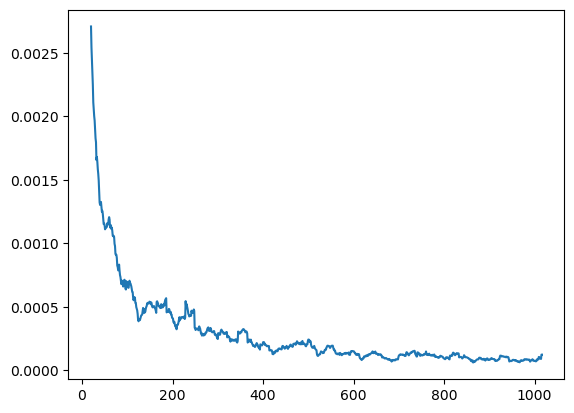

In [109]:
#TOP N ma quanti? 350, dove la derivata dell'aumento della percentuale delle vie totali considerata smette di aumentare significativamente
df_global.counts.div(df_global.counts.sum()).cumsum().diff().rolling(20).mean().head(1000).plot()

In [66]:
top50 = df_global.sort_values('counts', ascending=False).head(350)[['denominazione', 'counts']]
#top50 = df_global.sort_values('counts', ascending=False)[['denominazione', 'counts']]
top50['denominazione'] = top50['denominazione'].apply(lambda x: x.title())
top50 = top50.reset_index(drop=True)

citta = ['Mantova', 'Gorizia', 'Roma', 'Milano', 'Napoli', 'Torino', 'Palermo', 'Genova', 'Bologna', 'Firenze', 'Bari', 'Catania', 'Verona', 'Venezia', 'Messina', 'Padova', 'Trieste', 'Parma', 'Brescia', 'Prato', 'Taranto', 'Modena', 'Reggio Calabria', 'Reggio Emilia', 'Perugia', 'Ravenna', 'Livorno', 'Rimini', 'Cagliari', 'Foggia', 'Ferrara', 'Latina', 'Salerno', 'Giugliano in Campania', 'Monza', 'Sassari', 'Bergamo', 'Pescara', 'Trento', 'Forlì', 'Siracusa', 'Vicenza', 'Terni', 'Bolzano', 'Piacenza', 'Novara', 'Ancona', 'Udine', 'Andria', 'Arezzo', 'Cesena', 'Pesaro', 'Lecce', 'Barletta', 'La Spezia', 'Alessandria', 'Pistoia', 'Guidonia Montecelio', 'Lucca', 'Pisa', 'Catanzaro', 'Treviso', 'Como', 'Busto Arsizio', 'Brindisi', 'Fiumicino', 'Grosseto', 'Torre del Greco', 'Marsala', 'Sesto San Giovanni', 'Varese', 'Pozzuoli', 'Cinisello Balsamo', 'Aprilia', 'Corigliano-Rossano', 'Casoria', 'Asti', 'Ragusa', 'Caserta', 'Carpi', 'Gela', 'Cremona', 'Pavia', 'Altamura', "L'Aquila", 'Imola', "Quartu Sant'Elena", 'Lamezia Terme', 'Massa', 'Viterbo', 'Potenza', 'Cosenza', 'Castellammare di Stabia', 'Vittoria', 'Vigevano', 'Afragola', 'Pomezia', 'Viareggio', 'Olbia', 'Carrara', 'Matera', 'Legnano', 'Fano', 'Faenza', 'Caltanissetta', 'Savona', 'Crotone', 'Acerra', 'Marano di Napoli', 'Molfetta', 'Cerignola', 'Benevento', 'Moncalieri', 'Cuneo', 'Agrigento', 'Foligno', 'Trapani', 'Tivoli', 'Trani', 'Manfredonia', 'Gallarate', 'Bisceglie', 'Modica', 'Siena', 'Bitonto', 'Sanremo', 'Montesilvano', 'Velletri', 'Bagheria', 'Avellino', 'Anzio', 'Portici', 'Civitavecchia', 'Pordenone', 'Teramo', "Cava de' Tirreni", 'Rho', 'Acireale', 'Mazara del Vallo']
persone = ['Guglielmo Marconi', 
           'Giuseppe Garibaldi', 'Garibaldi',
           'Giacomo Matteotti', 'Giuseppe Mazzini', 'Dante Alighieri', 'Aldo Moro', 'Giuseppe Verdi', 'Antonio Gramsci', 'Alcide De Gasperi', 
           'Cesare Battisti', 'Alessandro Manzoni', 'Leonardo Da Vinci', 'Cristoforo Colombo', 'Enrico Fermi', 'Giosuè Carducci', 'Alessandro Volta', 
           'Galileo Galilei', 'Giacomo Leopardi', 'Giovanni Pascoli', 'Sandro Pertini', 'Umberto I', 'Giuseppe Di Vittorio', 'Ugo Foscolo', 
           'Cavour', 'Camillo Benso Conte Di Cavour',
          'Armando Diaz','Vittorio Emanuele','Giacomo Puccini', 'Enrico Berlinguer',
           'Papa Giovanni Xxiii', 'Giovanni Xxiii', 'Papa Giovanni Ventitreesimo',
           'Nazario Sauro', "Salvo D'Acquisto", 'Luigi Einaudi', "Gabriele D'Annunzio",
          'Palmiro Togliatti', 'Fratelli Cervi', 'Silvio Pellico', 'John Fitzgerald Kennedy', 'Filippo Turati', 'Francesco Petrarca', 'Vittorio Emanuele Ii',
          'Michelangelo Buonarroti', 'Vincenzo Bellini', 'Regina Margherita', 'Gaetano Donizetti', 'Pietro Nenni', 'Don Giovanni Minzoni', 'Amerigo Vespucci',
          'Gioacchino Rossini', 'Fratelli Rosselli', 'Bruno Buozzi', 'Goffredo Mameli', 'Giotto', 'Don Luigi Sturzo', 'Marco Polo', 'Giovanni Falcone',
          'Pietro Mascagni', 'Fratelli Bandiera', 'Enrico Mattei', 'Nino Bixio', 'Vittorio Alfieri', 'Guglielmo Oberdan', 'Raffaello Sanzio', 'Giovanni Amendola',
          'Grazia Deledda', 'Edmondo De Amicis', 'Benedetto Croce', 'Achille Grandi', 'Luigi Cadorna', 'Luigi Pirandello',
          "Torquato Tasso", "Ludovico Ariosto", "Enrico Toti", "Paolo Borsellino", "Francesco Crispi", "Fabio Filzi", "Carlo Alberto Dalla Chiesa", "Giovanni Verga", 
           "Giuseppe Parini", "Giovanni Boccaccio", "Antonio Vivaldi", "Massimo D'Azeglio", "Arturo Toscanini", "Antonio Meucci", 'Francesco Baracca', 'Fabio Filzi',
          'Martin Luther King', "Duca D'Aosta", 'Ugo La Malfa', 'Eugenio Montale', 'Salvador Allende', 'Giuseppe Giusti', 'Caravaggio', 'Giordano Bruno', 'Luigi Galvani',
          'Vittorio Emanuele Iii', 'Giulio Cesare', 'Enrico De Nicola', 'Don Minzoni', 'Ippolito Nievo', 'Giuseppe Ungaretti', 'Salvatore Quasimodo', 'Guido Rossa', 'Felice Cavallotti',
          'Arrigo Boito', 'Carlo Pisacane', 'Giacomo Brodolini', 'Filippo Corridoni', 'Virgilio', 'Damiano Chiesa', 'Regina Elena', 'Giovanni Paolo Ii',
          'Carlo Cattaneo', 'Pietro Micca', 'Carlo Alberto', 'Archimede', 'Fratelli Cairoli', 'Andrea Costa', 'Madre Teresa Di Calcutta', 'Duca Degli Abruzzi',
          'Ciro Menotti', 'Cesare Pavese', 'Pio La Torre', 'Piero Gobetti', 'Daniele Manin', 'Vincenzo Monti']
santi = ['San Rocco', 'San Martino', "Sant'Antonio", 'San Francesco', 'San Giovanni', 'San Pietro', 'San Giuseppe', 'Santa Maria',
        'San Marco', 'Santa Lucia', 'San Lorenzo', 'San Michele', 'San Giorgio', "Sant'Anna", 'San Giovanni Bosco', 'San Vito',
        "San Giacomo",  "Santa Caterina",  "Santo Stefano",  "San Sebastiano",  "Sant'Andrea", 'Santa Croce', 'San Carlo', 'San Paolo',
        'San Nicola', 'San Benedetto', 'San Donato', 'San Biagio', 'San Bartolomeo', "Sant'Agostino", 'San Domenico', 'Madonna', 'Madonna Delle Grazie']
storia = ['Vittorio Veneto', 'Quattro Novembre', 'Piave', 'Venticinque Aprile', 'Primo Maggio', 'Ventiquattro Maggio', 'Due Giugno', 'Zara', 'Palestro',
          'Risorgimento', 'Venti Settembre', 'Monte Grappa', 'Isonzo', 'Mille', 'Fiume', 'Solferino', 'Magenta', 'Adua', 'Carso',
         'Cavalieri Di Vittorio Veneto', 'Marzabotto']
geografia = ['Lombardia', 'Emilia', 'Mediterraneo', 'Europa',  'Italia', 'Adriatica', 'Provinciale', 'Stazione', 'Aurelia', 
             'Piemonte', 'Toscana',  'Cassia', 'Flaminia',  'Costa', 
             'Francia', "Valle D'Aosta", 'Liguria', 'Lombardia', 'Piemonte', "Trentino-Alto Adige", 'Veneto', 'Friuli-Venezia Giulia', 'Emilia-Romagna',
            'Toscana', 'Umbria', 'Abruzzo', 'Marche', 'Lazio', 'Molise', 'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia', 'Sardegna',
            'Trafori', 'Tripoli', 'Brenta', 'Monte', 'Romagna', 'Aquileia', 'Friuli', 'Romana',
            'Dalmazia', 'Pola', 'Cisa']
elementi_geografici = ['Sole', 'Po', 'Adige', 'Monte Rosa', 'Tagliamento', 'Sempione', 'Arno', 'Volturno', 'Sud', 'Tevere',
                      'Pasubio', 'Est', 'Ovest', 'Nord', 'Ticino', 'Adige', 'Valle', 'Bosco', 'Monte Bianco', 'Brennero', 'Colli']
astratti = ['Libertà', 'Martiri Della Libertà', 'Pace', "Industria", "Artigianato", "Vittoria", "Resistenza", 'Nazionale', 'Fiori',
            'Libertà', 'Lavoro', 'Indipendenza', 'Serenissima', 'Indipendenza', 'Alpini', 'Nuova', 'Popolo', 'Parchi', 'Mare', 'Costituzione', 
            'Rose', 'Pini', 'Ulivi', 'Azzurra', 'Industrie', "Unità D'Italia", 'Maestri Del Lavoro', 'Tigli', 'Commercio', 'Sport', 
            'Repubblica', 'Cappuccini', 'Rimembranze', 'Martiri', 'Rimembranza', 'Concordia', 'Donatori Di Sangue', 'Ginestre', 'Caduti', 'Liberazione']
luoghi_civici = ['Belvedere', 'Castello', 'Chiesa', 'Circonvallazione', 'Stazione', 'Montello', 'Stazione', 'Chiesa', 'Fontana',
                'Municipio', 'Cimitero', 'Torre', 'Molino', 'Fornace', 'Orti', 'Croce', 'Duomo', 'Mercato', 'Giardini', 'Molini', 'Mulino', 'Mulini',
                'Ponte', 'Mezzo',
                'Fornaci', 'Olmo', 'Casale', 'Poggio', 'Santuario', 'Prati', 'Pozzo', 'Rocca', 'Panoramica', 'Statale', 'Scuole', 'Borgo',
                'Montebello', 'Forno', 'Ospedale', 'Porto', 'Madonnina', 'Villa', 'Carmine', 'Lago', 'Fontanelle',
                'Castellana', 'Ronchi']
statali = ['Statale 16 Adriatica', 'Statale 106 Jonica', 'Statale 3 Bis Tiberina', 'Statale 77 Della Val Di Chienti', 'Autostrada Del Brennero', 
          "Statale 17 Dell'Appennino Abruzzese E Appulo Sannitico", 'Messinapalermo',  'Statale 1 Aurelia']

top50["categoria"] = ''
top50["categoria"] = np.where(top50["denominazione"].isin(citta), "Città italiane", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(persone), "Personalità", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(storia), "Eventi storici", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(santi), "Santi", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(geografia), "Geografia politica", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(elementi_geografici), "Elementi geografici", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(astratti), "Entità astratte", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(luoghi_civici), "Luoghi civici", top50["categoria"])
top50["categoria"] = np.where(top50["denominazione"].isin(statali), "Statali", top50["categoria"])
top50["categoria"] = np.where(top50["categoria"] == '', "altro", top50["categoria"])
#top50.sort_values('categoria', ascending=False)
top50[top50['categoria']=='altro']


,denominazione,counts,categoria


In [67]:
def plot_barh(data, figsize=None):
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.barh(data.denominazione, data.counts)
    for bars in ax.containers:
        ax.bar_label(bars, padding=5, fmt='%g')
    plt.box(False)
    plt.tick_params(bottom=False, labelbottom=False) #remove ticks
    plt.tick_params(axis='both', which='both', length=0)
    fig.tight_layout()
    return plt

def to_snake_case(value):
    return "_".join(value.lower().split())

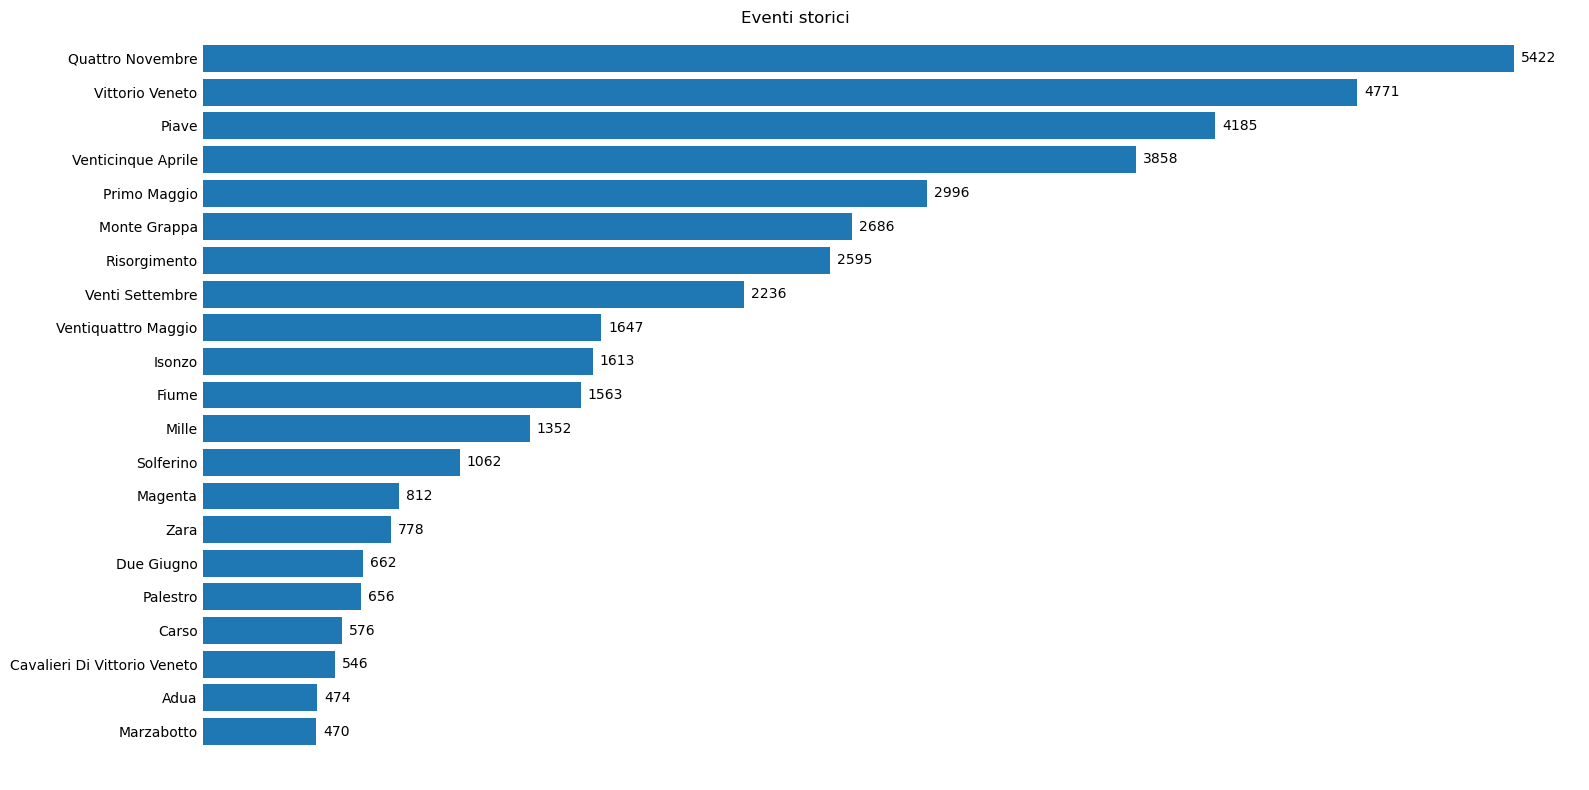

In [68]:
cat = 'Eventi storici' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(16,8))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

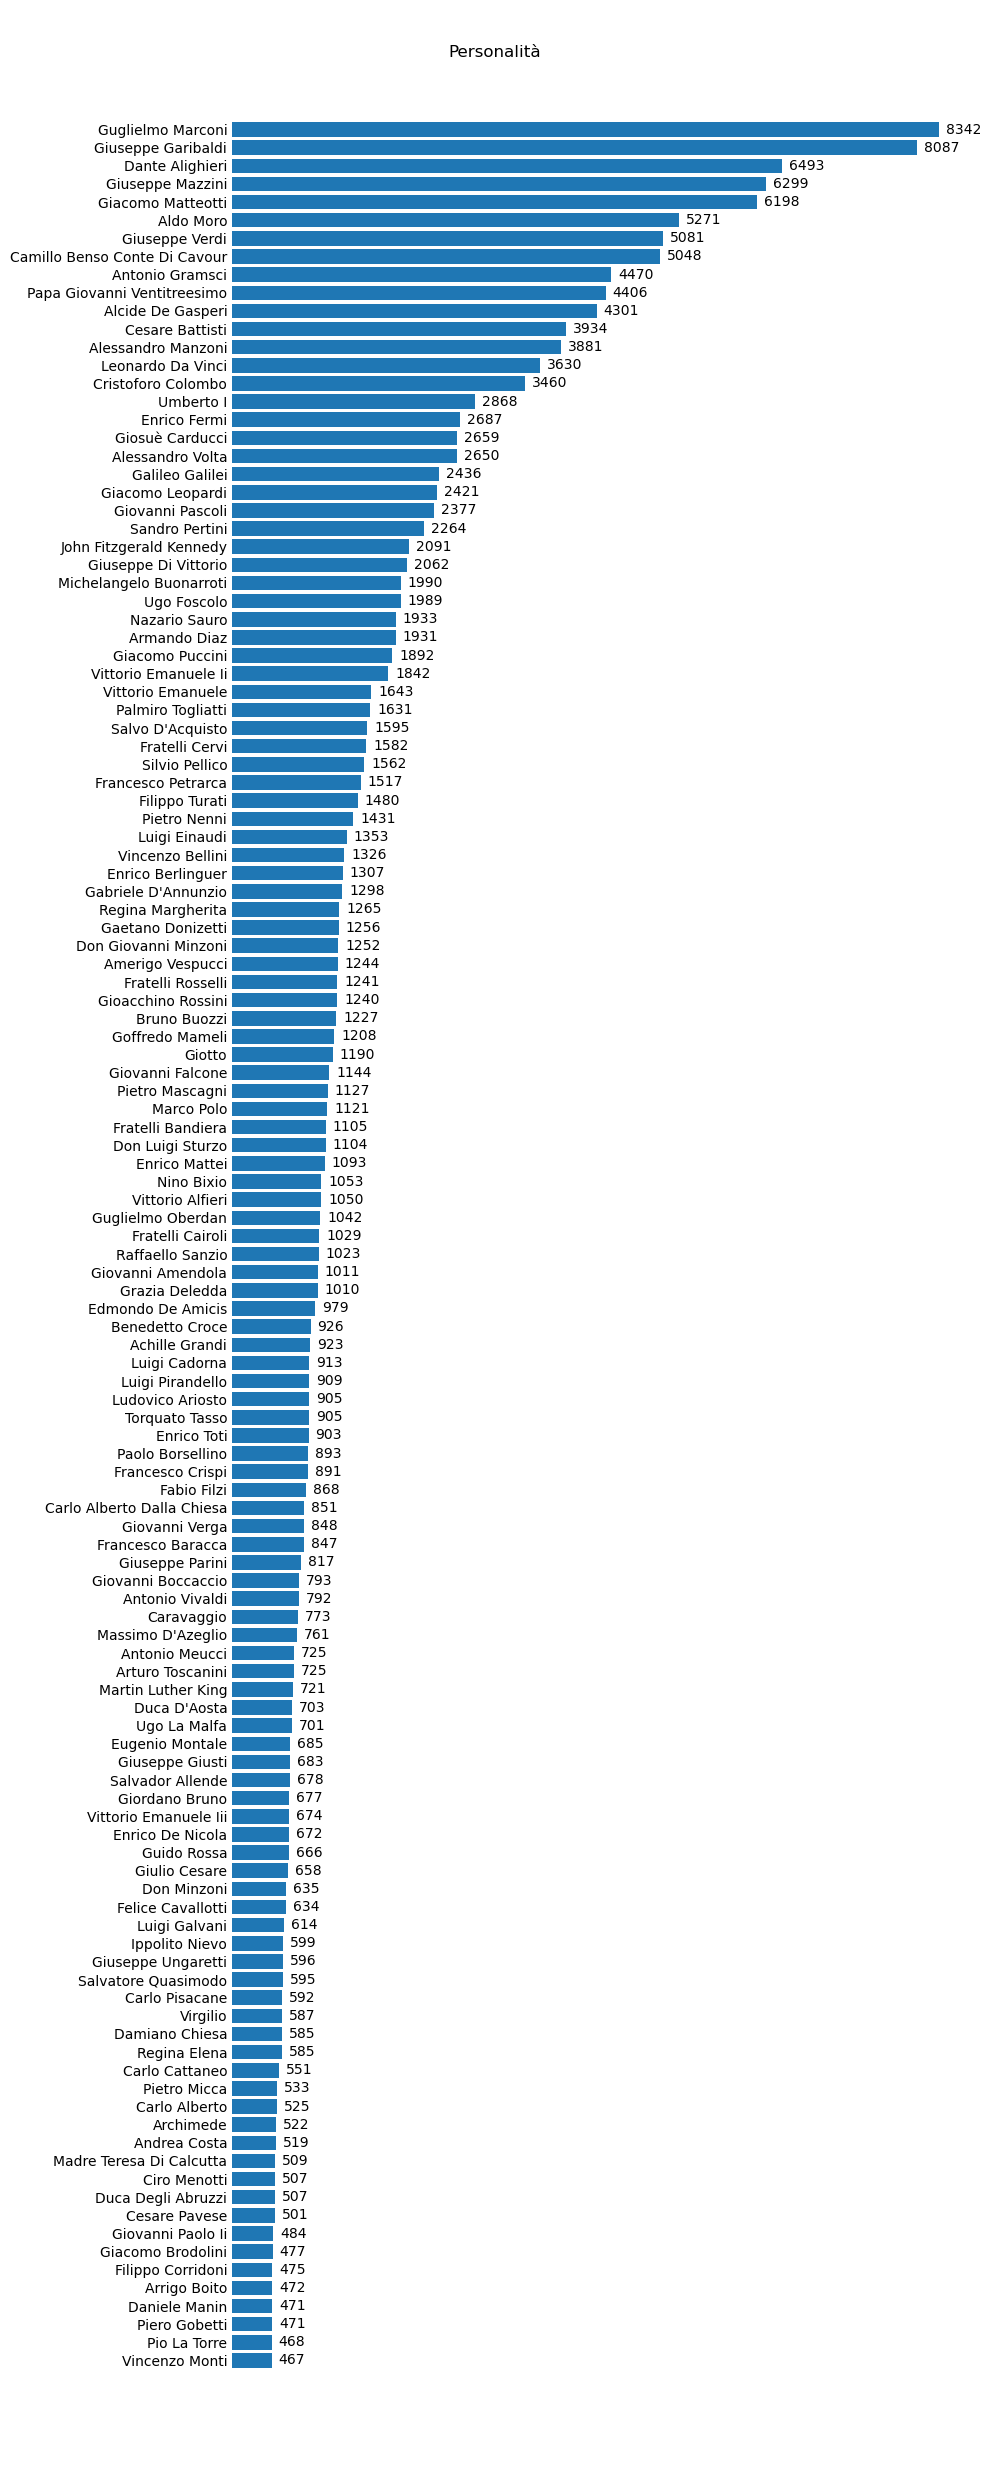

In [69]:
cat = 'Personalità' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,25))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

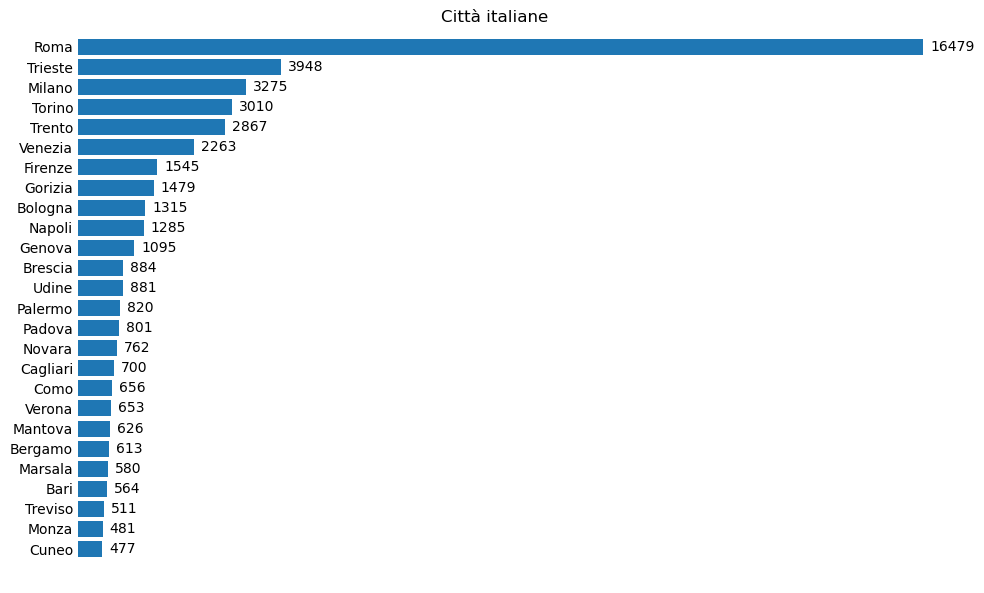

In [70]:
cat = 'Città italiane' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,6))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

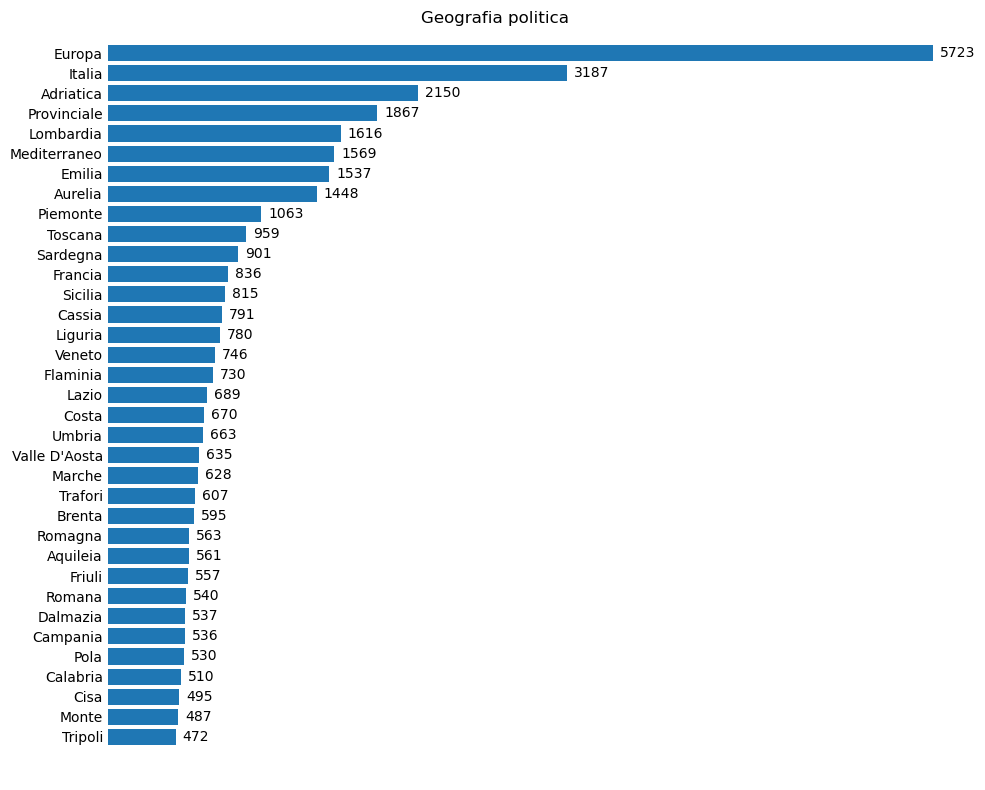

In [71]:
cat = 'Geografia politica' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,8))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

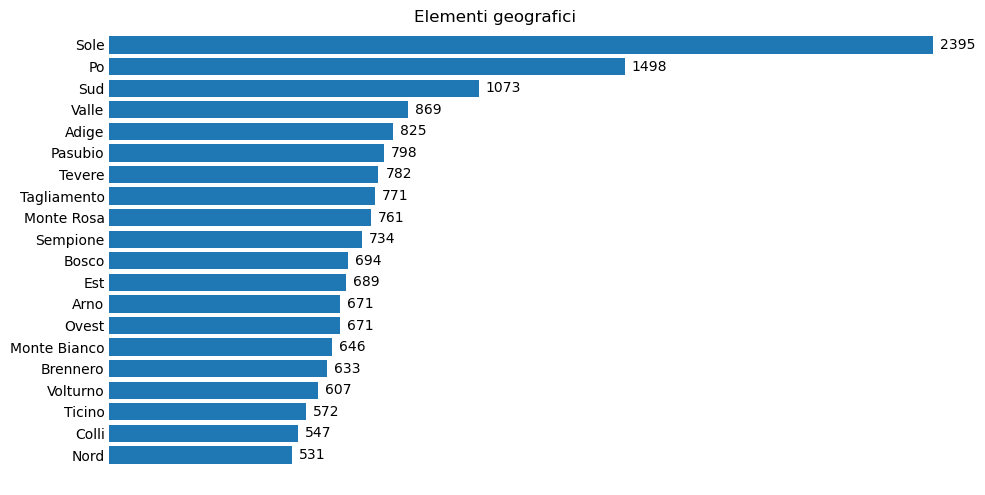

In [72]:
cat = 'Elementi geografici' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,5))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

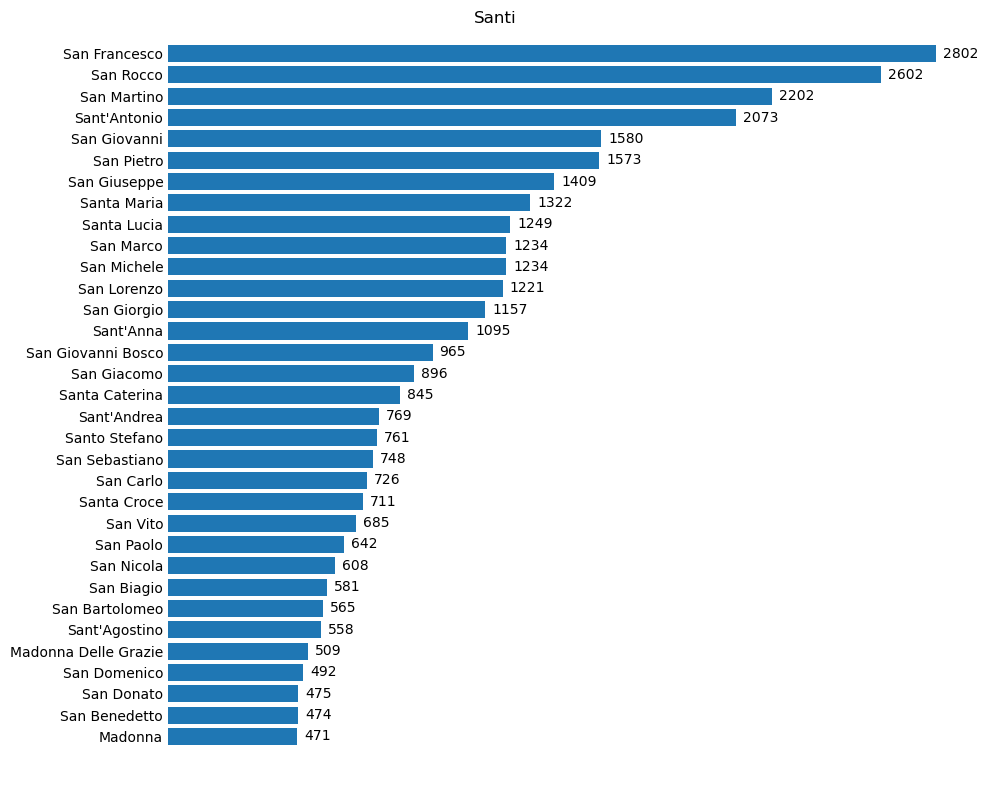

In [73]:
cat = 'Santi' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,8))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

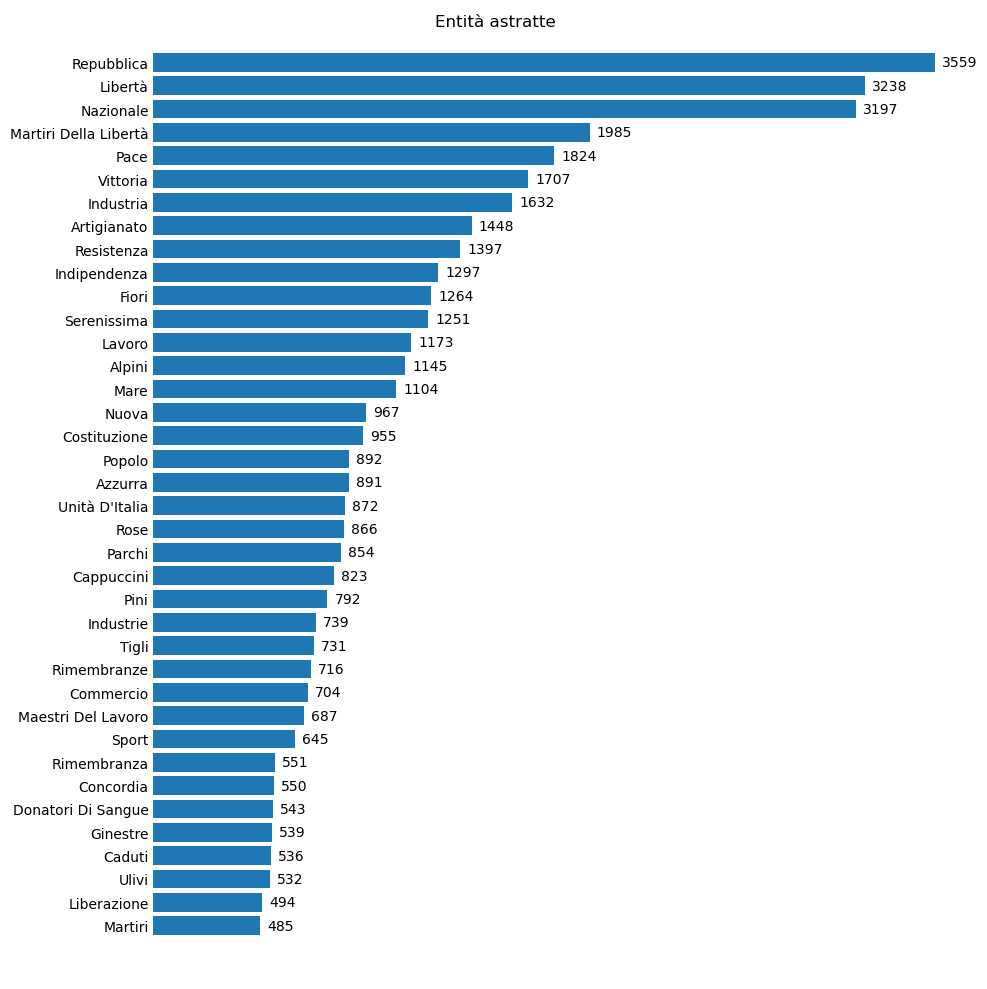

In [74]:
cat = 'Entità astratte' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,10))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

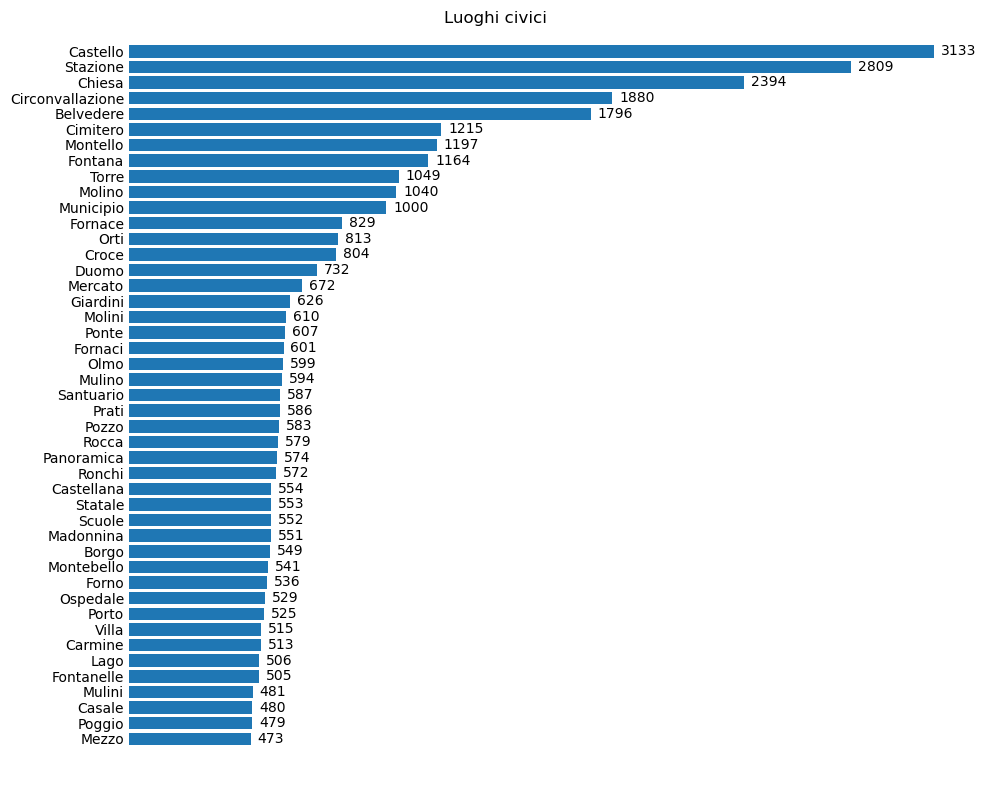

In [75]:
cat = 'Luoghi civici' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,8))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

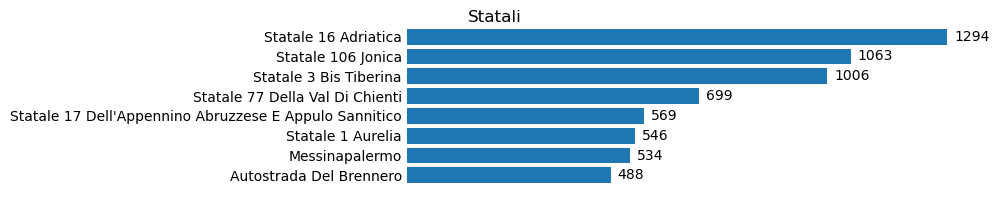

In [76]:
cat = 'Statali' 
to50_cat = top50[top50.categoria==cat].sort_values('counts')

plt = plot_barh(to50_cat, figsize=(10,2))
plt.suptitle(cat)
plt.savefig('./output/'+to_snake_case(cat)+'.png')

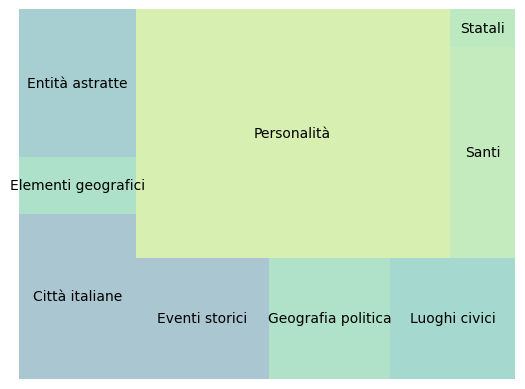

In [77]:
#libraries
import matplotlib.pyplot as plt
import squarify # pip install squarify (algorithm for treemap)

totale_vie= df_global.sort_values('counts', ascending=False)[['counts']].sum()
top_350 = df_global.sort_values('counts', ascending=False).head(350)[['counts']].sum()

# Change color
squarify.plot(sizes=top50.groupby(['categoria']).sum().counts, label=top50.groupby(['categoria']).sum().index, alpha=.4 )
plt.axis('off')
plt.show()

In [78]:
top50_count = df_global.sort_values('counts', ascending=False).head(350)['counts'].sum()
n_vie_totali = df_global.sort_values('counts', ascending=False)['counts'].sum()
n_vie_uniche = df_global.sort_values('counts', ascending=False)['counts'].shape[0]
tropN_total_ratio = topN_count / n_vie_totali
overall_ratios = [tropN_total_ratio, 1-tropN_total_ratio]
overall_labels = ['Top 350', 'Restanti']
explode = [ 0, 0]

In [79]:
def bar_fo_pie(overall_ratios, overall_labels, focus_ratios, focus_labels, title=None, top_left_note=None, bottom_left_note=None):
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
    import matplotlib.pyplot as plt
    from matplotlib.patches import ConnectionPatch
    import numpy as np

    # make figure and assign axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    fig.subplots_adjust(wspace=0)
    fig.suptitle(title)

    # pie chart parameters
    #overall_ratios = [.27, .56, .17]
    #labels = ['Approve', 'Disapprove', 'Undecided']
    #explode = [0.1, 0, 0]
    # rotate so that first wedge is split by the x-axis
    angle = -180 * overall_ratios[0]
    wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                         labels=overall_labels, explode=explode, pctdistance=0.8)
    #ax1.set_title(sub_title1, loc='left', fontsize=10)
    # draw circle
    centre_circle = plt.Circle((0, 0), 0.60, fc='white')
    ax1.add_artist(centre_circle)

    # bar chart parameters
    #focus_ratios = [.33, .54, .07, .06]
    #focus_labels = ['Under 35', '35-49', '50-65', 'Over 65']
    bottom = 1
    width = 0.6

    # Adding from the top matches the legend.
    incr_height = sum(focus_ratios)
    for j, (height, label) in enumerate(reversed([*zip(focus_ratios, focus_labels)])):
        bottom -= height
        incr_height = incr_height-height
        bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                     alpha=0.1 + (0.9/len(focus_ratios)) * j)
        ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center', fontsize=10)
        ax2.text(width/2 +0.025, incr_height+height/2 -0.015, label, fontsize=10)

    #ax2.set_title('Categorie denominazione')
    #ax2.legend(loc=1, prop={'size': 8})
    ax2.axis('off')
    ax2.set_xlim(- 2.5 * width, 2.5 * width)

    # use ConnectionPatch to draw lines between the two plots
    theta1, theta2 = wedges[0].theta1, wedges[0].theta2
    center, r = wedges[0].center, wedges[0].r
    bar_height = sum(focus_ratios)

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(1)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(1)
    
    #bottom left note
    fig.text(0.05, 0.1,  bottom_left_note, fontsize=10)  
    #top left note
    fig.text(0.05, .8,  top_left_note, fontsize=10)
    return plt

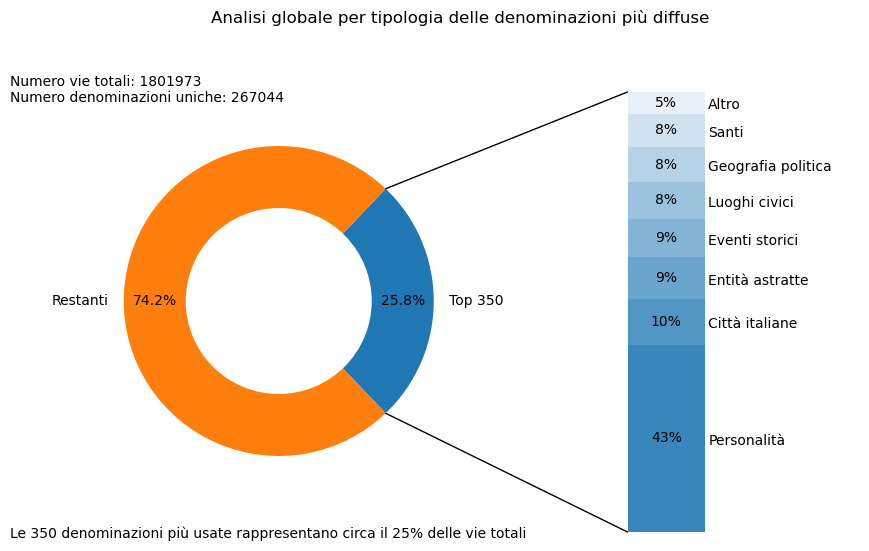

In [80]:
top50 = top50.replace({'categoria' : {'Statali' : 'Altro', 'Elementi geografici' : 'Altro'}})

top50_gr = top50.groupby(['categoria']).sum().sort_values(by='counts', ascending=False)
focus_ratios = list(top50_gr.counts/topN_count)
focus_labels = list(top50_gr.index)

titolo = 'Analisi globale per tipologia delle denominazioni più diffuse'
top_left_note = f'Numero vie totali: {int(n_vie_totali)}\nNumero denominazioni uniche: {n_vie_uniche}\n'
bottom_left_note = f'Le 350 denominazioni più usate rappresentano circa il 25% delle vie totali'
plt = bar_fo_pie(overall_ratios, overall_labels, focus_ratios, focus_labels, title=titolo, top_left_note=top_left_note, bottom_left_note=bottom_left_note)
#plt.show()

#plt.show()
plt.savefig('./output/'+to_snake_case(titolo)+'.png')